## First generate an image with Flux Schnell

In [1]:
import torch
from diffusers import FluxPipeline
from diffusers.utils import load_image
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from utils import preprocess_image,pil_to_cv2,cv2_to_pil, show_image_cv2, clear_gpu_memory,run_with_conda_env
import copy
from diffusion_utils import load_pipeline,generate_outpaint,fix_mask, fix_inpaint_mask, vis_inpaint_strategy,composite_with_mask, load_contolnet_pipeline,outpaint_controlnet
import torch
from dust3r_infer import get_focals
from image_utils import *
import copy

GEN = False
USE_SDXL = False

IMAGE_SIZE = 1024
if GEN == True:
	pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16)
	pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power
	prompt = "a town square in a city with a person standing in the center"
	image = pipe(
		prompt,
		guidance_scale=0.0,
		num_inference_steps=4,
		max_sequence_length=256,
		generator=torch.Generator("cpu").manual_seed(0)
	).images[0]
	image.save("middle.jpg")
	clear_gpu_memory()
	focals = get_focals('middle.jpg', 512)
	source_image_cv2 = pil_to_cv2(image)
	show_image_cv2(source_image_cv2)



Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/home/cedric/PanoramaGenInpaint/dust3r/dust3r/cloud_opt/base_opt.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Use Dust3R to estimate the FOV and map it to the equirectangular image

In [2]:
if GEN and DUST3R : 
	h_fov = focal_to_fov(focals[0], 512)  # Assuming 512 is your reference dimension
	print(f"Horizontal FOV: {h_fov} degrees")
	equirectangular_image,non_wrapped = image_to_equirectangular(source_image_cv2, h_fov, 2028*4,1024*4,wrap_around=True)
	cv2_to_pil(equirectangular_image).save("imgs/initial_pano_with_back.png")
	cv2_to_pil(non_wrapped).save("imgs/initial_pano_center.png")
	show_image_cv2(equirectangular_image)

## Visualisation of rough inpainting regions

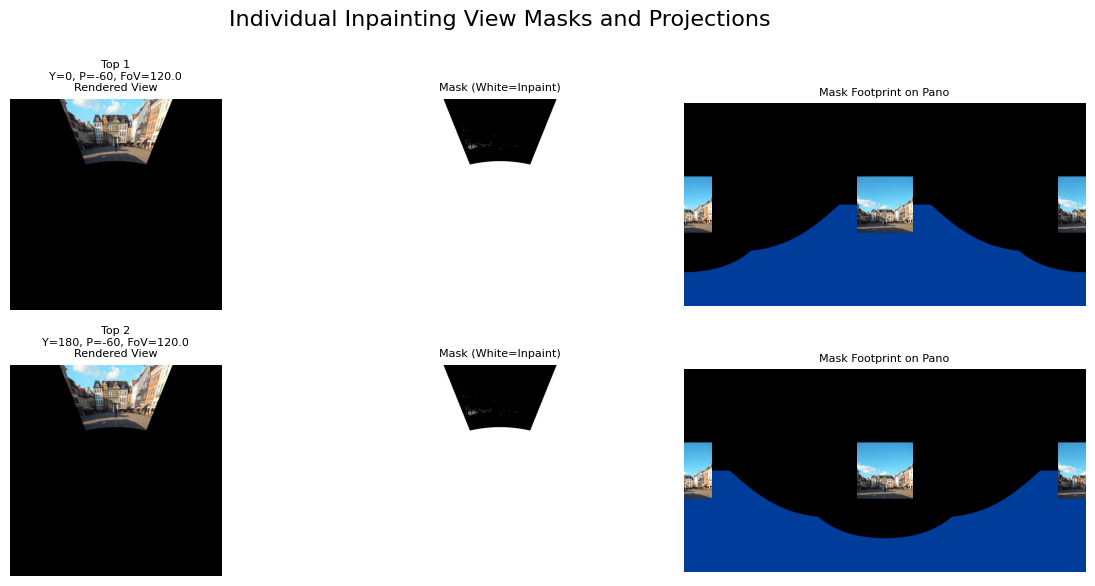

In [3]:
all_views_data = vis_inpaint_strategy()